# 📘 Twitter Duygu Analizi

# ============================
# 📦 1. Gerekli Kütüphanelerin Kurulumu
# ============================
# Huggingface Transformers: BERT modeli ve tokenizer için
# scikit-learn: metrikler ve veri bölme için
# torch: PyTorch modeli ve eğitim işlemleri için

In [1]:
!pip install transformers
!pip install scikit-learn
!pip install torch torchvision torchaudio
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 38.1 MB/s eta 0:00:00


# ============================
# Gerekli İmportlar
# ============================

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import emoji
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from torch.nn import CrossEntropyLoss
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_scheduler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
from google.colab import files

# ============================
# 📁 2. Ham Veriyi Yükleyelim (CSV)
# ============================
# Bilgisayardan veri yüklemek için arayüz açılır. Dosya olarak 'fifa_world_cup_2022_tweets.csv' dosyasını seçiyoruz.

In [3]:
uploaded = files.upload()

Saving fifa_world_cup_2022_tweets.csv to fifa_world_cup_2022_tweets.csv


# ============================
# 📚 3. Gerekli Python modüllerini yükle
# ============================
# Pandas: veri okuma ve düzenleme
# re: regex ile metin temizleme
# nltk: doğal dil işleme araçları (stopwords, lemmatization)
# matplotlib: grafik çizimi

In [4]:
# nltk verilerini indiriyoruz
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# ============================
# 🧹 4. Veriyi Oku ve Temizle
# ============================
# Tweet metinlerini temizliyoruz: link, kullanıcı adı, hashtag, noktalama, büyük harf

In [5]:
raw_df = pd.read_csv("fifa_world_cup_2022_tweets.csv")

def clean_text(text):
    text = re.sub(r'http\S+', '', text)         # Linkleri kaldır
    text = re.sub(r'@\w+', '', text)            # Mention (@user) kaldır
    text = re.sub(r'#', '', text)                # Hashtag işaretini kaldır
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Noktalama işaretlerini temizle
    text = text.lower()                          # Tümünü küçük harfe çevir
    return text

raw_df['Clean_Tweet'] = raw_df['Tweet'].apply(clean_text)

# ============================
# 🔠 5. Stopwords Temizliği + Lemmatization
# ============================
# Stopwords: anlamsız kelimeleri çıkarır (the, in, is)
# Lemmatization: kelimeleri kök haline indirger

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

raw_df['Processed_Tweet'] = raw_df['Clean_Tweet'].apply(preprocess_text)

# ============================
# 💾 6. Temiz Veriyi Kaydet
# ============================
# Eğitimde kullanılacak temiz tweetleri yeni CSV dosyasına kaydederiz.

In [7]:
raw_df[['Processed_Tweet', 'Sentiment']].to_csv("processed_tweets.csv", index=False)

# ============================
# 📊 7. Sentiment Dağılım Grafiği
# ============================
# Hangi duygu etiketi kaç adet içeriyor, bunu görselleştiriyoruz.

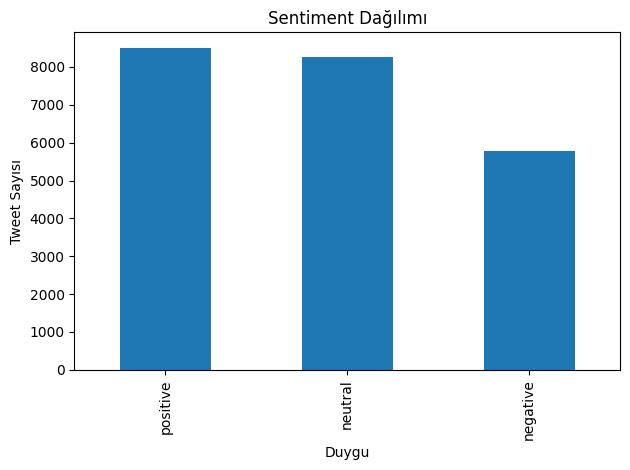

In [8]:
raw_df['Sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Dağılımı')
plt.xlabel('Duygu')
plt.ylabel('Tweet Sayısı')
plt.tight_layout()
plt.savefig("sentiment_distribution.png")
plt.show()

# ============================
# 🧪 8. Tokenizer ve Dataset Oluşturma
# ============================
# RoBERTa Tokenizer ile metni tokenlara çeviriyoruz, PyTorch Dataset ile model için hazır veri yapısı kuruyoruz.

In [9]:
# İşlenmiş CSV'den veriyi yükle
df = pd.read_csv("processed_tweets.csv")

# Tokenizer yükle (bert-base-uncased)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Metin ve etiket listelerini oluştur
texts = df['Processed_Tweet'].tolist()
labels = df['Sentiment'].tolist()
label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
numerical_labels = [label_map[label] for label in labels]

# Tokenizer ile encode et
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)

# PyTorch Dataset tanımı
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

dataset = TweetDataset(encodings, numerical_labels)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# ============================
# 🧪 9. Train/Test Böl ve DataLoader Ayarla
# ============================
# Eğitim ve test setini ayırıp PyTorch DataLoader ile batch'li şekilde kullanıma hazırlarız. Eğitim ve test setini 80 e 20 olarak ayırıyoruz.

In [10]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# ============================
# 🧠 10. Model Kurulumu ve Optimizasyon
# ============================
# BERT modelini 3 sınıflı hale getiriyoruz ve GPU kullanımı aktifse modele tanımlıyoruz.

In [11]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# AdamW optimizer + learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# ============================
# 🏋️‍♂️ 11. Model Eğitimi (3 Epoch kadar)
# ============================
# Model batch batch verilerle eğitilir. Loss değeri her batch'te güncellenir, epoch sonunda ortalama yazılır.

In [12]:
model.train()
epochs = 3

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    total_loss = 0
    progress_bar = tqdm(train_loader, desc="Eğitiliyor", leave=False)
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
    avg_loss = total_loss / len(train_loader)
    print(f"Ortalama Loss: {avg_loss:.4f}")


Epoch 1/3


Eğitiliyor:   0%|          | 0/1127 [00:00<?, ?it/s]

Ortalama Loss: 0.6448

Epoch 2/3


Eğitiliyor:   0%|          | 0/1127 [00:00<?, ?it/s]

Ortalama Loss: 0.4316

Epoch 3/3


Eğitiliyor:   0%|          | 0/1127 [00:00<?, ?it/s]

Ortalama Loss: 0.2908


# ============================
# 🧾 12. Model Testi ve Başarı Metrikleri
# ============================
# Test verisi ile doğruluk (accuracy) ve sınıf bazlı metrikler (precision, recall, F1-score) ölçülür.

In [13]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Metrik sonuçları
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Doğruluğu (Accuracy): {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_map.keys()))


Test Doğruluğu (Accuracy): 0.7711

Classification Report:
              precision    recall  f1-score   support

    positive       0.80      0.80      0.80      1644
     neutral       0.73      0.73      0.73      1675
    negative       0.80      0.79      0.79      1186

    accuracy                           0.77      4505
   macro avg       0.77      0.77      0.77      4505
weighted avg       0.77      0.77      0.77      4505



# ============================
# 🧾 13. Daha Güçlü Bir Model
# ============================
# En son yaptığımız modele birkaç değişiklik ekleyerek daha yüksek bir doğruluk oranı hedeflendi. Yapılan değişiklikler;
- Epoch sayısı arttırıldı → 3 ---> 6 epoch
- Learning rate optimize edildi → 2e-5 ---> 3e-5 lr
- Weighted loss fonksiyonu eklendi → class imbalance dengeleme
- RoBERTa-base modeli kullanıldı → BERT ---> RoBERTa-base model
- Emoji dönüştürme yapıldı (😍 → "happy" gibi)
- Kısaltma düzeltmeleri yapıldı ("im" → "i'm", "dont" → "don't" gibi)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/6


Eğitiliyor:   0%|          | 0/1127 [00:00<?, ?it/s]

Ortalama Loss: 0.6346

Epoch 2/6


Eğitiliyor:   0%|          | 0/1127 [00:00<?, ?it/s]

Ortalama Loss: 0.4455

Epoch 3/6


Eğitiliyor:   0%|          | 0/1127 [00:00<?, ?it/s]

Ortalama Loss: 0.3300

Epoch 4/6


Eğitiliyor:   0%|          | 0/1127 [00:00<?, ?it/s]

Ortalama Loss: 0.2317

Epoch 5/6


Eğitiliyor:   0%|          | 0/1127 [00:00<?, ?it/s]

Ortalama Loss: 0.1526

Epoch 6/6


Eğitiliyor:   0%|          | 0/1127 [00:00<?, ?it/s]

Ortalama Loss: 0.1036

Test Doğruluğu: 0.8018

Classification Report:
              precision    recall  f1-score   support

    positive       0.83      0.84      0.84      1708
     neutral       0.77      0.74      0.76      1636
    negative       0.80      0.82      0.81      1161

    accuracy                           0.80      4505
   macro avg       0.80      0.80      0.80      4505
weighted avg       0.80      0.80      0.80      4505



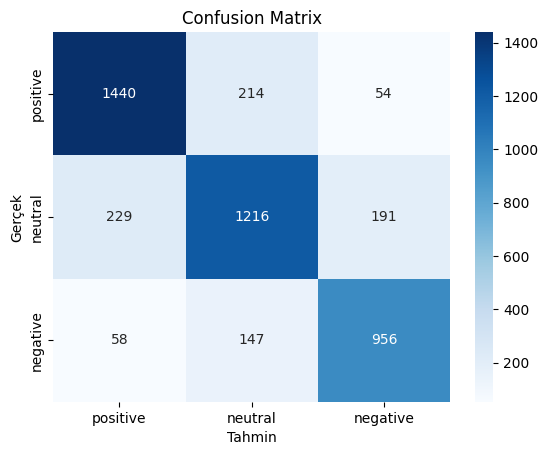

In [14]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = emoji.demojize(text)  # emojileri metne çevirir
    text = text.replace("im", "i'm").replace("dont", "don't").replace("cant", "can't")
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return text.lower()

raw_df = pd.read_csv("fifa_world_cup_2022_tweets.csv")
raw_df['Clean_Tweet2'] = raw_df['Tweet'].apply(clean_text)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

raw_df['Processed_Tweet2'] = raw_df['Clean_Tweet2'].apply(preprocess_text)

raw_df[['Processed_Tweet2', 'Sentiment']].to_csv("processed_tweets2.csv", index=False)


# Veriyi oku
df = pd.read_csv("processed_tweets2.csv")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
texts = df['Processed_Tweet2'].tolist()
labels = df['Sentiment'].tolist()
label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
numerical_labels = [label_map[label] for label in labels]

# Sınıf ağırlıklarını hesapla
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1, 2]), y=numerical_labels)
weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Encode işlemi
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)

class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

dataset = TweetDataset(encodings, numerical_labels)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


model2 = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
model2.to(device)

optimizer = AdamW(model2.parameters(), lr=3e-5)
num_training_steps = len(train_loader) * 6
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)



loss_fn = CrossEntropyLoss(weight=weights_tensor.to(device))
model2.train()
epochs = 6

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    total_loss = 0
    progress_bar = tqdm(train_loader, desc="Eğitiliyor", leave=False)
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model2(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        loss = loss_fn(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
    avg_loss = total_loss / len(train_loader)
    print(f"Ortalama Loss: {avg_loss:.4f}")



model2.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model2(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Accuracy ve rapor
acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Doğruluğu: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_map.keys()))

# Confusion Matrix
conf_mat = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys(), cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()
